In [1]:
import torch, gc
import random
import copy
import itertools
import numpy as np
import utils
from trainer import LIMTrainer
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sklearn.metrics import classification_report
from LIM_deep_neural_classifier import LIMDeepNeuralClassifier
import dataset_equality

gc.collect()
torch.cuda.empty_cache()

import seaborn as sns

In [2]:
# Variables to change
hidden_dim_per_slice = 4

# Fixed variables
device = "cuda:9"
data_size = 640000
embedding_dim = 4
num_layers = 3
max_iter = 10
hidden_dim = hidden_dim_per_slice * 4
input_dim = embedding_dim * 4

### Step 1: Generate all the dataset, save it for later use.

In [ ]:
for seed in {42, 77, 88}:
    print(f"generating dataset for seed={seed}")
    utils.fix_random_seeds(seed=seed)
    pool = utils.generate_shape_pool(embedding_dim, data_size)
    
    factual_equality_dataset = utils.get_factual_task_from_pool(pool)
    filehandler = open(f"./datasets/iit_equality_dataset_factual_{seed}.obj","wb")
    pickle.dump(factual_equality_dataset, filehandler)
    filehandler.close()
    
    # oracle
    iit_equality_dataset = \
        dataset_equality.get_IIT_equality_dataset_all(
        embedding_dim, 
        data_size,
        pool=pool
    )
    filehandler = open(f"./datasets/iit_equality_dataset_oracle_{seed}.obj","wb")
    pickle.dump(iit_equality_dataset, filehandler)
    filehandler.close()
    
    # control (0)
    key = {
        "left":(0),
        "right":()
    }
    train_datasetIIT = \
        dataset_equality.get_IIT_equality_dataset_control(
        key, 
        embedding_dim,   
        data_size,
        pool=pool
    )
    filehandler = open(f"./datasets/iit_equality_dataset_control_0_{seed}.obj","wb")
    pickle.dump(train_datasetIIT, filehandler)
    filehandler.close()
    
    # control (0, 1)
    key = {
        "left":(0,1),
        "right":()
    }
    train_datasetIIT = \
        dataset_equality.get_IIT_equality_dataset_control(
        key, 
        embedding_dim,   
        data_size
    )
    filehandler = open(f"./datasets/iit_equality_dataset_control_0_1_{seed}.obj","wb")
    pickle.dump(train_datasetIIT, filehandler)
    filehandler.close()

### Step 2: Train the factual model

In [ ]:
for seed in {42, 77, 88}:
    for hidden_dim in {32}: # {16, 32}
        utils.fix_random_seeds(seed=seed)
        print(f"training factual model for seed={seed}")
        LIM = LIMDeepNeuralClassifier(
            hidden_dim=hidden_dim, 
            hidden_activation=torch.nn.ReLU(), 
            num_layers=num_layers,
            input_dim=input_dim,
            n_classes=2,
            device=device
        )

        filehandler = open(f"./datasets/iit_equality_dataset_factual_{seed}.obj",'rb')
        factual_equality_dataset = pickle.load(filehandler)
        X_base_train, y_base_train = factual_equality_dataset

        LIM_trainer = LIMTrainer(
            LIM,
            warm_start=True,
            max_iter=max_iter,
            batch_size=6400,
            n_iter_no_change=10000,
            shuffle_train=False,
            eta=0.001,
            save_checkpoint_per_epoch=True,
            seed=seed
        )

        _ = LIM_trainer.fit(
            X_base_train, 
            y_base_train, 
            iit_data=None,
            intervention_ids_to_coords=None
        )

        datasetIIT = dataset_equality.get_IIT_equality_dataset_both(embedding_dim, 1000)
        base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = datasetIIT
        base_preds = LIM_trainer.predict(base_test, device="cpu")
        print(classification_report(y_base_test, base_preds))

        PATH = f"./saved_models/basemodel-last-{num_layers}-{hidden_dim}-{seed}.bin"
        torch.save(LIM_trainer.model.state_dict(), PATH)

### Step 3: Train oracle model with d-IIT
We should expect this to have a really high d-IIT accuracies! We evaluate these models in the next step!

In [ ]:
model_c = 1
total_model_c = 135
for seed in {42, 77, 88}:
    utils.fix_random_seeds(seed=seed)
    filehandler = open(f"./datasets/iit_equality_dataset_oracle_{seed}.obj",'rb')
    train_datasetIIT = pickle.load(filehandler)
    filehandler.close()
    X_base_train, y_base_train = train_datasetIIT[0:2]
    iit_data = tuple(train_datasetIIT[2:])
    for hidden_dim in {32}: # {16, 32}
        for hidden_dim_per_concept in {0.5, 1, 4}:
            for iit_layer in [0, 1, 2]:
                scale_factor = hidden_dim/8
                id_to_coords = {
                    0: [{"layer": iit_layer, "start": 0, "end": int(scale_factor*hidden_dim_per_concept)}],
                    1: [{"layer": iit_layer, "start":  int(scale_factor*hidden_dim_per_concept), "end": int(2*scale_factor*hidden_dim_per_concept)}],
                    2: [{"layer": iit_layer, "start": 0, "end": int(scale_factor*hidden_dim_per_concept)}, 
                        {"layer": iit_layer, "start":  int(scale_factor*hidden_dim_per_concept), "end": int(2*scale_factor*hidden_dim_per_concept)}],
                }
                for i in [2, 4, 6, 8, 10]:
                    print(f"Training {model_c}/{total_model_c} model aligned with oracle hlm with params:")
                    print(f"seed={seed}")
                    print(f"hidden_dim_per_concept={hidden_dim_per_concept}")
                    print(f"iit_layer={iit_layer}")
                    print(f"epoch={i}")
                    LIM = LIMDeepNeuralClassifier(
                        hidden_dim=hidden_dim, 
                        hidden_activation=torch.nn.ReLU(), 
                        num_layers=num_layers,
                        input_dim=input_dim,
                        n_classes=2,
                        device=device
                    )

                    LIM_trainer = LIMTrainer(
                        LIM,
                        warm_start=True,
                        max_iter=10,
                        batch_size=6400, # we need to make sure in batch iit id is the same!
                        n_iter_no_change=10000,
                        shuffle_train=False,
                        eta=0.001,
                        device=device
                    )

                    PATH = f"./saved_models/basemodel-{i}-{num_layers}-{hidden_dim}-{seed}.bin"
                    LIM_trainer.model.load_state_dict(torch.load(PATH))
                    LIM_trainer.model.set_analysis_mode(True)

                    _ = LIM_trainer.fit(
                        X_base_train, 
                        y_base_train, 
                        iit_data=iit_data,
                        intervention_ids_to_coords=id_to_coords)

                    iit_layer_out = iit_layer + 1
                    PATH = f"./saved_models/iit-oraclemodel-epoch{i}-"\
                           f"{iit_layer_out}-{hidden_dim}-{hidden_dim_per_concept}-"\
                           f"{seed}.bin"
                    torch.save(LIM_trainer.model.state_dict(), PATH)

                    model_c += 1

### Step 3: Evaluate oracle model with d-IIT


In [3]:
oracle_results = []
model_c = 1
for seed in {42, 77, 88}: # {42, 66, 77}
    utils.fix_random_seeds(seed=seed)
    filehandler = open(f"./datasets/iit_equality_dataset_oracle_{seed}.obj",'rb')
    train_datasetIIT = pickle.load(filehandler)
    filehandler.close()
    base_test_train, y_base_test_train, sources_test_train, y_IIT_test_train, intervention_ids_test_train = \
        utils.get_eval_from_train(
            train_datasetIIT, 6400
        )

    base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = \
        dataset_equality.get_IIT_equality_dataset_all(embedding_dim, 6400)
    for hidden_dim in {16, 32}: # {16, 32}
        for hidden_dim_per_concept in {0.5, 1, 4}: # {0.1, 1, 4}
            for iit_layer in [0, 1, 2]: # {0, 1, 2}
                scale_factor = hidden_dim/8
                id_to_coords = {
                    0: [{"layer": iit_layer, "start": 0, "end": int(scale_factor*hidden_dim_per_concept)}],
                    1: [{"layer": iit_layer, "start":  int(scale_factor*hidden_dim_per_concept), "end": int(2*scale_factor*hidden_dim_per_concept)}],
                    2: [{"layer": iit_layer, "start": 0, "end": int(scale_factor*hidden_dim_per_concept)}, 
                        {"layer": iit_layer, "start":  int(scale_factor*hidden_dim_per_concept), "end": int(2*scale_factor*hidden_dim_per_concept)}],
                }
                for i in [2, 4, 6, 8, 10]: # {2, 4, 6, 8, 10}
                    # print(f"Evaluating {model_c}/135 model aligned with oracle hlm.")
                    LIM = LIMDeepNeuralClassifier(
                        hidden_dim=hidden_dim, 
                        hidden_activation=torch.nn.ReLU(), 
                        num_layers=num_layers,
                        input_dim=input_dim,
                        n_classes=2,
                        device=device
                    )

                    LIM_trainer = LIMTrainer(
                        LIM,
                        warm_start=True,
                        max_iter=10,
                        batch_size=6400, # we need to make sure in batch iit id is the same!
                        n_iter_no_change=10000,
                        shuffle_train=False,
                        eta=0.001,
                        device=device
                    )

                    iit_layer_out = iit_layer + 1
                    PATH = f"./saved_models/iit-oraclemodel-epoch{i}-"\
                           f"{iit_layer_out}-{hidden_dim}-{hidden_dim_per_concept}-"\
                           f"{seed}.bin"
                    LIM_trainer.model.load_state_dict(torch.load(PATH))
                    LIM_trainer.model.set_analysis_mode(True)

                    # train data eval
                    base_preds_train = LIM_trainer.predict(
                        base_test_train, device="cpu"
                    )
                    IIT_preds_train = LIM_trainer.iit_predict(
                        base_test_train, sources_test_train, 
                        intervention_ids_test_train, 
                        id_to_coords, device="cpu"
                    )
                    r1_train = classification_report(y_base_test_train, base_preds_train, output_dict=True)
                    r2_train = classification_report(y_IIT_test_train, IIT_preds_train, output_dict=True)

                    # test data eval
                    base_preds = LIM_trainer.predict(
                        base_test, device="cpu"
                    )
                    IIT_preds = LIM_trainer.iit_predict(
                        base_test, sources_test, 
                        intervention_ids_test, 
                        id_to_coords, device="cpu"
                    )
                    r1 = classification_report(y_base_test, base_preds, output_dict=True)
                    r2 = classification_report(y_IIT_test, IIT_preds, output_dict=True)

                    oracle_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "Factual Train", r1_train["weighted avg"]["f1-score"]]
                    )
                    oracle_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "d-IIT Train", r2_train["weighted avg"]["f1-score"]]
                    )
                    oracle_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "Factual Test", r1["weighted avg"]["f1-score"]]
                    )
                    oracle_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "d-IIT Test", r2["weighted avg"]["f1-score"]]
                    )
                    model_c += 1
oracle_df = pd.DataFrame(
    oracle_results,
    columns =['seed', 'hidden_dim', 'hidden_dim_per_concept', 'iit_layer', 'epoch', 
              'type', 'f1-score']
)

### Step 4: Train (0, ) control model with d-IIT

In [ ]:
key = {
    "left":0,
    "right":( )
}
model_c = 1
total_model_c = 135
for seed in {42, 77, 88}:
    filehandler = open(f"./datasets/iit_equality_dataset_control_0_{seed}.obj",'rb')
    train_datasetIIT = pickle.load(filehandler)
    filehandler.close()
    X_base_train, y_base_train = train_datasetIIT[0:2]
    iit_data = tuple(train_datasetIIT[2:])
    for hidden_dim in {16, 32}: # {16, 32}
        for hidden_dim_per_concept in {0.5, 1, 4}:
            scale_factor = hidden_dim/8
            for iit_layer in [0, 1, 2]:
                if key["left"] in [0,1] and key["right"] in [0,1]:
                    key_size = 2
                elif key["left"] == (0,1) and key["right"] == (0,1):
                    key_size = 4
                elif key["left"] == (0,1) and key["right"] == ():
                    key_size = 2
                elif key["left"] == () and key["right"] == (0,1):
                    key_size = 2
                elif key["left"] == () or key["right"] == ():
                    key_size = 1
                else:
                    key_size = 3
                control = 3
                id_to_coords = {
                    control:[{
                        "layer": iit_layer, 
                        "start": 0, 
                        "end": int(scale_factor*key_size*hidden_dim_per_concept)
                    }]
                }
                print(id_to_coords)
                for i in [2,4,6,8,10]:
                    print(f"Training {model_c}/{total_model_c} model aligned with oracle hlm with params:")
                    print(f"seed={seed}")
                    print(f"hidden_dim_per_concept={hidden_dim_per_concept}")
                    print(f"iit_layer={iit_layer}")
                    print(f"epoch={i}")
                    LIM = LIMDeepNeuralClassifier(
                        hidden_dim=hidden_dim, 
                        hidden_activation=torch.nn.ReLU(), 
                        num_layers=num_layers,
                        input_dim=input_dim,
                        n_classes=2,
                        device=device
                    )

                    LIM_trainer = LIMTrainer(
                        LIM,
                        warm_start=True,
                        max_iter=10,
                        batch_size=6400, # we need to make sure in batch iit id is the same!
                        n_iter_no_change=10000,
                        shuffle_train=False,
                        eta=0.001,
                        device=device
                    )

                    PATH = f"./saved_models/basemodel-{i}-{num_layers}-{hidden_dim}-{seed}.bin"
                    LIM_trainer.model.load_state_dict(torch.load(PATH))
                    LIM_trainer.model.set_analysis_mode(True)

                    _ = LIM_trainer.fit(
                        X_base_train, 
                        y_base_train, 
                        iit_data=iit_data,
                        intervention_ids_to_coords=id_to_coords)

                    iit_layer_out = iit_layer + 1
                    PATH = f"./saved_models/iit-controlmodel-0-epoch{i}-"\
                           f"{iit_layer_out}-{hidden_dim}-{hidden_dim_per_concept}-"\
                           f"{seed}.bin"
                    torch.save(LIM_trainer.model.state_dict(), PATH)

                    model_c += 1

{3: [{'layer': 0, 'start': 0, 'end': 1}]}
Training 1/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=0
epoch=2


Finished epoch 10 of 10; error is 128.56031584739685

Training 2/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=0
epoch=4


Finished epoch 10 of 10; error is 230.96647310256958

Training 3/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=0
epoch=6


Finished epoch 10 of 10; error is 352.1037485599518

Training 4/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=0
epoch=8


Finished epoch 10 of 10; error is 433.3498020172119

Training 5/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=0
epoch=10


Finished epoch 10 of 10; error is 499.0703420639038

{3: [{'layer': 1, 'start': 0, 'end': 1}]}
Training 6/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=1
epoch=2


Finished epoch 10 of 10; error is 128.14558362960815

Training 7/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=1
epoch=4


Finished epoch 10 of 10; error is 208.9084494113922

Training 8/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=1
epoch=6


Finished epoch 10 of 10; error is 322.97167444229126

Training 9/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=1
epoch=8


Finished epoch 10 of 10; error is 400.72157168388367

Training 10/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=1
epoch=10


Finished epoch 10 of 10; error is 462.45656633377075

{3: [{'layer': 2, 'start': 0, 'end': 1}]}
Training 11/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=2
epoch=2


Finished epoch 10 of 10; error is 125.90163767337799

Training 12/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=2
epoch=4


Finished epoch 10 of 10; error is 194.05086612701416

Training 13/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=2
epoch=6


Finished epoch 10 of 10; error is 296.8502457141876

Training 14/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=2
epoch=8


Finished epoch 10 of 10; error is 367.8767943382263

Training 15/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=0.5
iit_layer=2
epoch=10


Finished epoch 10 of 10; error is 425.07337069511414

{3: [{'layer': 0, 'start': 0, 'end': 2}]}
Training 16/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=0
epoch=2


Finished epoch 10 of 10; error is 127.93819892406464

Training 17/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=0
epoch=4


Finished epoch 10 of 10; error is 216.72844314575195

Training 18/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=0
epoch=6


Finished epoch 10 of 10; error is 335.41197657585144

Training 19/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=0
epoch=8


Finished epoch 10 of 10; error is 421.51731991767883

Training 20/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=0
epoch=10


Finished epoch 10 of 10; error is 488.0477476119995

{3: [{'layer': 1, 'start': 0, 'end': 2}]}
Training 21/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=1
epoch=2


Finished epoch 10 of 10; error is 125.6427321434021

Training 22/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=1
epoch=4


Finished epoch 10 of 10; error is 204.04631805419922

Training 23/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=1
epoch=6


Finished epoch 10 of 10; error is 316.2879042625427

Training 24/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=1
epoch=8


Finished epoch 10 of 10; error is 397.0881154537201

Training 25/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=1
epoch=10


Finished epoch 10 of 10; error is 459.40780544281006

{3: [{'layer': 2, 'start': 0, 'end': 2}]}
Training 26/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=2
epoch=2


Finished epoch 10 of 10; error is 125.89456367492676

Training 27/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=2
epoch=4


Finished epoch 10 of 10; error is 193.92048716545105

Training 28/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=2
epoch=6


Finished epoch 10 of 10; error is 296.65458846092224

Training 29/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=2
epoch=8


Finished epoch 10 of 10; error is 367.7351531982422

Training 30/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=1
iit_layer=2
epoch=10


Finished epoch 10 of 10; error is 424.96058893203735

{3: [{'layer': 0, 'start': 0, 'end': 8}]}
Training 31/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=0
epoch=2


Finished epoch 10 of 10; error is 127.1180249452591

Training 32/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=0
epoch=4


Finished epoch 10 of 10; error is 216.14662981033325

Training 33/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=0
epoch=6


Finished epoch 10 of 10; error is 349.9292743206024

Training 34/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=0
epoch=8


Finished epoch 10 of 10; error is 431.36963415145874

Training 35/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=0
epoch=10


Finished epoch 10 of 10; error is 489.74944734573364

{3: [{'layer': 1, 'start': 0, 'end': 8}]}
Training 36/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=1
epoch=2


Finished epoch 10 of 10; error is 125.82668793201447

Training 37/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=1
epoch=4


Finished epoch 10 of 10; error is 204.7930692434311

Training 38/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=1
epoch=6


Finished epoch 10 of 10; error is 316.2486550807953

Training 39/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=1
epoch=8


Finished epoch 10 of 10; error is 387.0561728477478

Training 40/135 model aligned with oracle hlm with params:
seed=88
hidden_dim_per_concept=4
iit_layer=1
epoch=10


Finished epoch 1 of 10; error is 606.9491381645203

### Step 5: Eval (0, ) control model with d-IIT

In [4]:
key = {
    "left":0,
    "right":( )
}
control_0_results = []
model_c = 1
for seed in {42, 77, 88}: # {42, 66, 77}
    utils.fix_random_seeds(seed=seed)
    filehandler = open(f"./datasets/iit_equality_dataset_control_0_{seed}.obj",'rb')
    train_datasetIIT = pickle.load(filehandler)
    filehandler.close()
    base_test_train, y_base_test_train, sources_test_train, y_IIT_test_train, intervention_ids_test_train = \
        utils.get_eval_from_train(
            train_datasetIIT, 6400*3, control=True
        )

    base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = \
        dataset_equality.get_IIT_equality_dataset_control(
        key, 
        embedding_dim,   
        6400*3,
    )
    for hidden_dim in {16, 32}: # {16, 32}
        for hidden_dim_per_concept in {0.5, 1, 4}:
            scale_factor = hidden_dim/8
            for iit_layer in [0, 1, 2]:
                if key["left"] in [0,1] and key["right"] in [0,1]:
                    key_size = 2
                elif key["left"] == (0,1) and key["right"] == (0,1):
                    key_size = 4
                elif key["left"] == (0,1) and key["right"] == ():
                    key_size = 2
                elif key["left"] == () and key["right"] == (0,1):
                    key_size = 2
                elif key["left"] == () or key["right"] == ():
                    key_size = 1
                else:
                    key_size = 3
                control = 3
                id_to_coords = {
                    control:[{
                        "layer": iit_layer, 
                        "start": 0, 
                        "end": int(scale_factor*key_size*hidden_dim_per_concept)
                    }]
                }
                for i in [2, 4, 6, 8, 10]: # {2, 4, 6, 8, 10}
                    # print(f"Evaluating {model_c}/135 model aligned with oracle hlm.")
                    LIM = LIMDeepNeuralClassifier(
                        hidden_dim=hidden_dim, 
                        hidden_activation=torch.nn.ReLU(), 
                        num_layers=num_layers,
                        input_dim=input_dim,
                        n_classes=2,
                        device=device
                    )

                    LIM_trainer = LIMTrainer(
                        LIM,
                        warm_start=True,
                        max_iter=10,
                        batch_size=6400, # we need to make sure in batch iit id is the same!
                        n_iter_no_change=10000,
                        shuffle_train=False,
                        eta=0.001,
                        device=device
                    )

                    iit_layer_out = iit_layer + 1
                    PATH = f"./saved_models/iit-controlmodel-0-epoch{i}-"\
                           f"{iit_layer_out}-{hidden_dim}-{hidden_dim_per_concept}-"\
                           f"{seed}.bin"
                    LIM_trainer.model.load_state_dict(torch.load(PATH))
                    LIM_trainer.model.set_analysis_mode(True)

                    # train data eval
                    base_preds_train = LIM_trainer.predict(
                        base_test_train, device="cpu"
                    )
                    IIT_preds_train = LIM_trainer.iit_predict(
                        base_test_train, sources_test_train, 
                        intervention_ids_test_train, 
                        id_to_coords, device="cpu"
                    )
                    r1_train = classification_report(y_base_test_train, base_preds_train, output_dict=True)
                    r2_train = classification_report(y_IIT_test_train, IIT_preds_train, output_dict=True)

                    # test data eval
                    base_preds = LIM_trainer.predict(
                        base_test, device="cpu"
                    )
                    IIT_preds = LIM_trainer.iit_predict(
                        base_test, sources_test, 
                        intervention_ids_test, 
                        id_to_coords, device="cpu"
                    )
                    r1 = classification_report(y_base_test, base_preds, output_dict=True)
                    r2 = classification_report(y_IIT_test, IIT_preds, output_dict=True)

                    control_0_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "Factual Train", r1_train["weighted avg"]["f1-score"]]
                    )
                    control_0_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "d-IIT Train", r2_train["weighted avg"]["f1-score"]]
                    )
                    control_0_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "Factual Test", r1["weighted avg"]["f1-score"]]
                    )
                    control_0_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "d-IIT Test", r2["weighted avg"]["f1-score"]]
                    )
                    model_c += 1
control_0_df = pd.DataFrame(
    control_0_results,
    columns =['seed', 'hidden_dim', 'hidden_dim_per_concept', 'iit_layer', 'epoch', 
              'type', 'f1-score']
)

In [ ]:
df_toplot = control_0_df[(control_0_df["hidden_dim_per_concept"]==4)&
   (control_0_df["iit_layer"]==1)]
sns.lineplot(
    data=df_toplot,
    x="epoch", y="f1-score", hue="type", style="type",
    markers=True, dashes=False
)

### Step 4: Train (0, 1) control model with d-IIT

In [ ]:
key = {
    "left":(0,1),
    "right":( )
}
model_c = 1
total_model_c = 90
for seed in {42, 77, 88}:
    filehandler = open(f"./datasets/iit_equality_dataset_control_0_1_{seed}.obj",'rb')
    train_datasetIIT = pickle.load(filehandler)
    filehandler.close()
    X_base_train, y_base_train = train_datasetIIT[0:2]
    iit_data = tuple(train_datasetIIT[2:])
    for hidden_dim in {32}: # {16, 32}
        for hidden_dim_per_concept in {0.5, 1, 4}:
            scale_factor = hidden_dim/16
            for iit_layer in [0, 1, 2]:
                if key["left"] in [0,1] and key["right"] in [0,1]:
                    key_size = 2
                elif key["left"] == (0,1) and key["right"] == (0,1):
                    key_size = 4
                elif key["left"] == (0,1) and key["right"] == ():
                    key_size = 2
                elif key["left"] == () and key["right"] == (0,1):
                    key_size = 2
                elif key["left"] == () or key["right"] == ():
                    key_size = 1
                else:
                    key_size = 3
                control = 3
                id_to_coords = {
                    control:[{
                        "layer": iit_layer, 
                        "start": 0, 
                        "end": int(scale_factor*key_size*hidden_dim_per_concept)
                    }]
                }
                for i in [2,4,6,8,10]:
                    print(f"Training {model_c}/{total_model_c} model aligned with oracle hlm with params:")
                    print(f"seed={seed}")
                    print(f"hidden_dim_per_concept={hidden_dim_per_concept}")
                    print(f"iit_layer={iit_layer}")
                    print(f"epoch={i}")
                    LIM = LIMDeepNeuralClassifier(
                        hidden_dim=hidden_dim, 
                        hidden_activation=torch.nn.ReLU(), 
                        num_layers=num_layers,
                        input_dim=input_dim,
                        n_classes=2,
                        device=device
                    )

                    LIM_trainer = LIMTrainer(
                        LIM,
                        warm_start=True,
                        max_iter=10,
                        batch_size=6400, # we need to make sure in batch iit id is the same!
                        n_iter_no_change=10000,
                        shuffle_train=False,
                        eta=0.001,
                        device=device
                    )

                    PATH = f"./saved_models/basemodel-{i}-{num_layers}-{hidden_dim}-{seed}.bin"
                    LIM_trainer.model.load_state_dict(torch.load(PATH))
                    LIM_trainer.model.set_analysis_mode(True)

                    _ = LIM_trainer.fit(
                        X_base_train, 
                        y_base_train, 
                        iit_data=iit_data,
                        intervention_ids_to_coords=id_to_coords)

                    iit_layer_out = iit_layer + 1
                    PATH = f"./saved_models/iit-controlmodel-0-1-epoch{i}-"\
                           f"{iit_layer_out}-{hidden_dim}-{hidden_dim_per_concept}-"\
                           f"{seed}.bin"
                    torch.save(LIM_trainer.model.state_dict(), PATH)

                    model_c += 1

### Step 5: Eval (0, 1) control model with d-IIT

In [5]:
key = {
    "left":(0, 1),
    "right":( )
}
control_0_1_results = []
model_c = 1
for seed in {42, 77, 88}: # {42, 66, 77}
    utils.fix_random_seeds(seed=seed)
    filehandler = open(f"./datasets/iit_equality_dataset_control_0_1_{seed}.obj",'rb')
    train_datasetIIT = pickle.load(filehandler)
    filehandler.close()
    base_test_train, y_base_test_train, sources_test_train, y_IIT_test_train, intervention_ids_test_train = \
        utils.get_eval_from_train(
            train_datasetIIT, 6400*3, control=True
        )

    base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = \
        dataset_equality.get_IIT_equality_dataset_control(
        key, 
        embedding_dim,   
        6400*3,
    )
    for hidden_dim in {16, 32}: # {16, 32}
        for hidden_dim_per_concept in {0.5, 1, 4}:
            scale_factor = hidden_dim/16
            for iit_layer in [0, 1, 2]:
                if key["left"] in [0,1] and key["right"] in [0,1]:
                    key_size = 2
                elif key["left"] == (0,1) and key["right"] == (0,1):
                    key_size = 4
                elif key["left"] == (0,1) and key["right"] == ():
                    key_size = 2
                elif key["left"] == () and key["right"] == (0,1):
                    key_size = 2
                elif key["left"] == () or key["right"] == ():
                    key_size = 1
                else:
                    key_size = 3
                control = 3
                id_to_coords = {
                    control:[{
                        "layer": iit_layer, 
                        "start": 0, 
                        "end": int(scale_factor*key_size*hidden_dim_per_concept)
                    }]
                }
                for i in [2, 4, 6, 8, 10]: # {2, 4, 6, 8, 10}
                    # print(f"Evaluating {model_c}/135 model aligned with oracle hlm.")
                    LIM = LIMDeepNeuralClassifier(
                        hidden_dim=hidden_dim, 
                        hidden_activation=torch.nn.ReLU(), 
                        num_layers=num_layers,
                        input_dim=input_dim,
                        n_classes=2,
                        device=device
                    )

                    LIM_trainer = LIMTrainer(
                        LIM,
                        warm_start=True,
                        max_iter=10,
                        batch_size=6400, # we need to make sure in batch iit id is the same!
                        n_iter_no_change=10000,
                        shuffle_train=False,
                        eta=0.001,
                        device=device
                    )

                    iit_layer_out = iit_layer + 1
                    PATH = f"./saved_models/iit-controlmodel-0-1-epoch{i}-"\
                           f"{iit_layer_out}-{hidden_dim}-{hidden_dim_per_concept}-"\
                           f"{seed}.bin"
                    LIM_trainer.model.load_state_dict(torch.load(PATH))
                    LIM_trainer.model.set_analysis_mode(True)

                    # train data eval
                    base_preds_train = LIM_trainer.predict(
                        base_test_train, device="cpu"
                    )
                    IIT_preds_train = LIM_trainer.iit_predict(
                        base_test_train, sources_test_train, 
                        intervention_ids_test_train, 
                        id_to_coords, device="cpu"
                    )
                    r1_train = classification_report(y_base_test_train, base_preds_train, output_dict=True)
                    r2_train = classification_report(y_IIT_test_train, IIT_preds_train, output_dict=True)

                    # test data eval
                    base_preds = LIM_trainer.predict(
                        base_test, device="cpu"
                    )
                    IIT_preds = LIM_trainer.iit_predict(
                        base_test, sources_test, 
                        intervention_ids_test, 
                        id_to_coords, device="cpu"
                    )
                    r1 = classification_report(y_base_test, base_preds, output_dict=True)
                    r2 = classification_report(y_IIT_test, IIT_preds, output_dict=True)

                    control_0_1_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "Factual Train", r1_train["weighted avg"]["f1-score"]]
                    )
                    control_0_1_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "d-IIT Train", r2_train["weighted avg"]["f1-score"]]
                    )
                    control_0_1_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "Factual Test", r1["weighted avg"]["f1-score"]]
                    )
                    control_0_1_results.append(
                        [
                            seed, hidden_dim, hidden_dim_per_concept, iit_layer_out, i, 
                            "d-IIT Test", r2["weighted avg"]["f1-score"]]
                    )
                    model_c += 1
control_0_1_df = pd.DataFrame(
    control_0_1_results,
    columns =['seed', 'hidden_dim', 'hidden_dim_per_concept', 
              'iit_layer', 'epoch', 
              'type', 'f1-score']
)

Construct results for the paper
- oracle_df
- control_0_df
- control_0_1_df

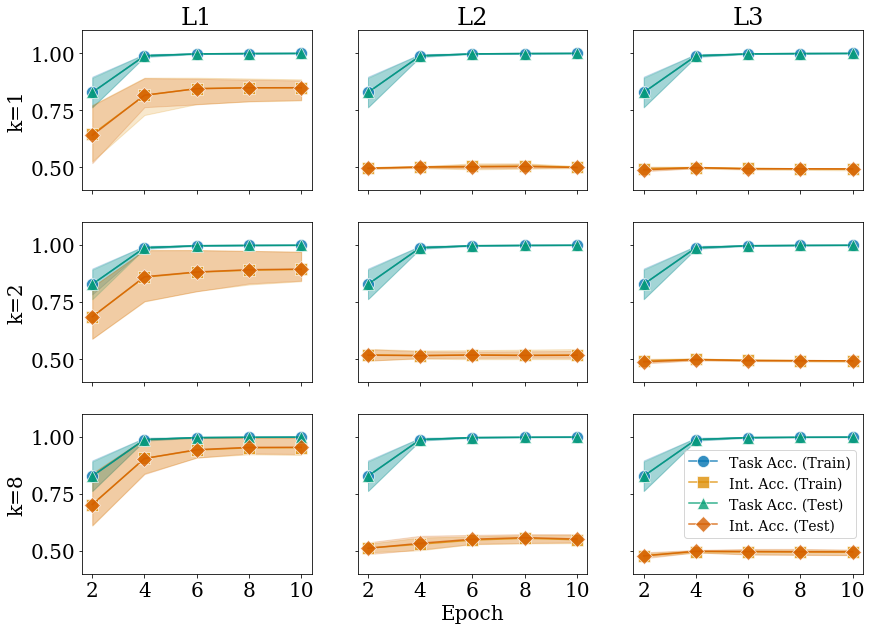

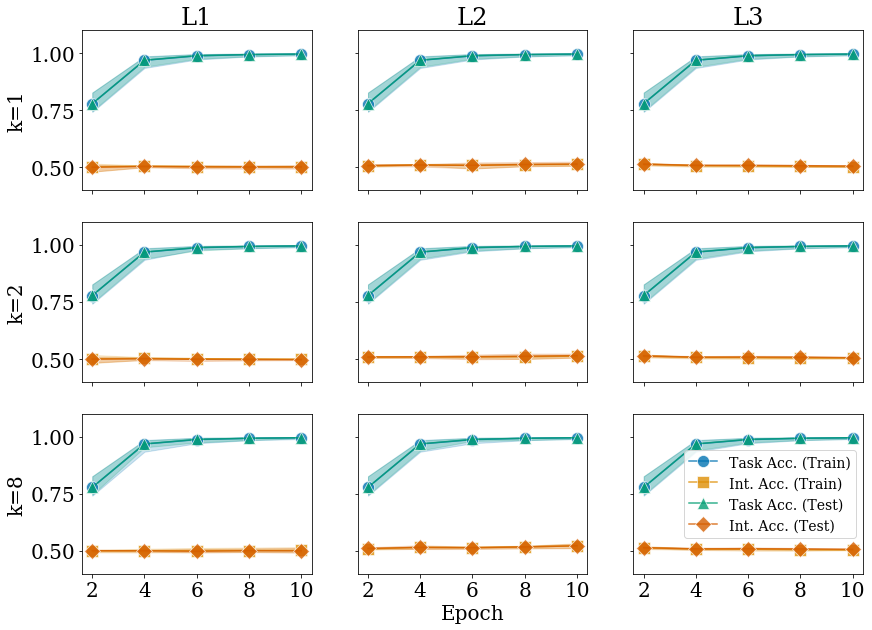

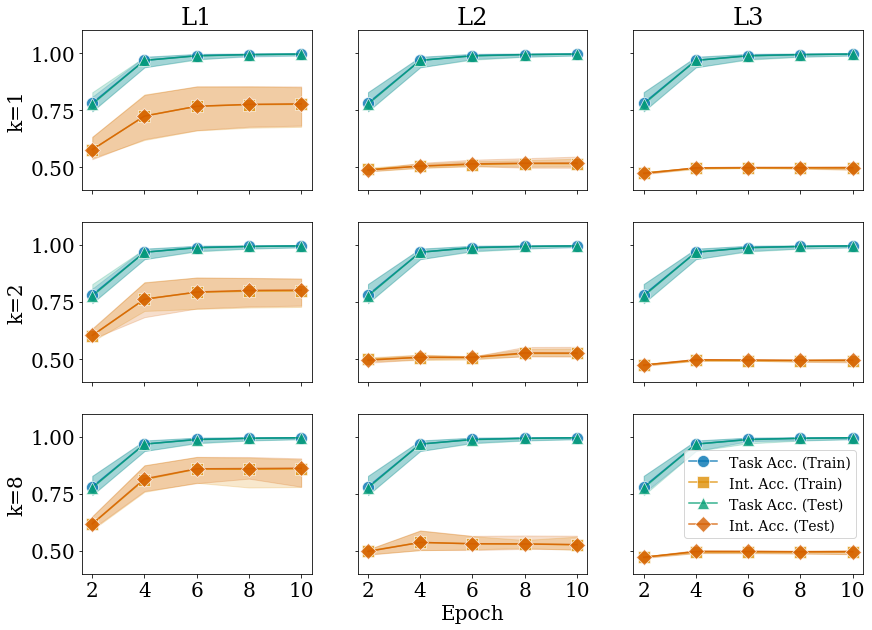

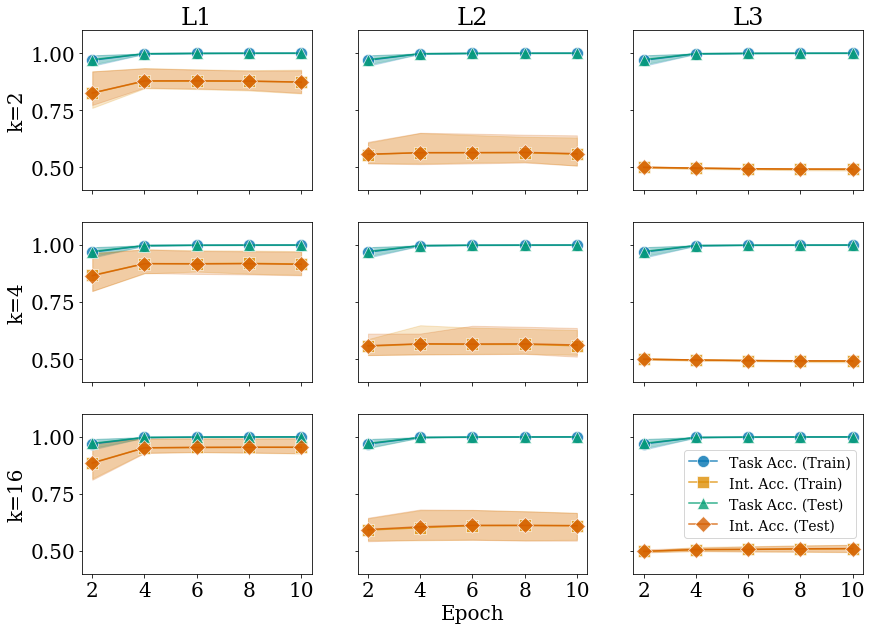

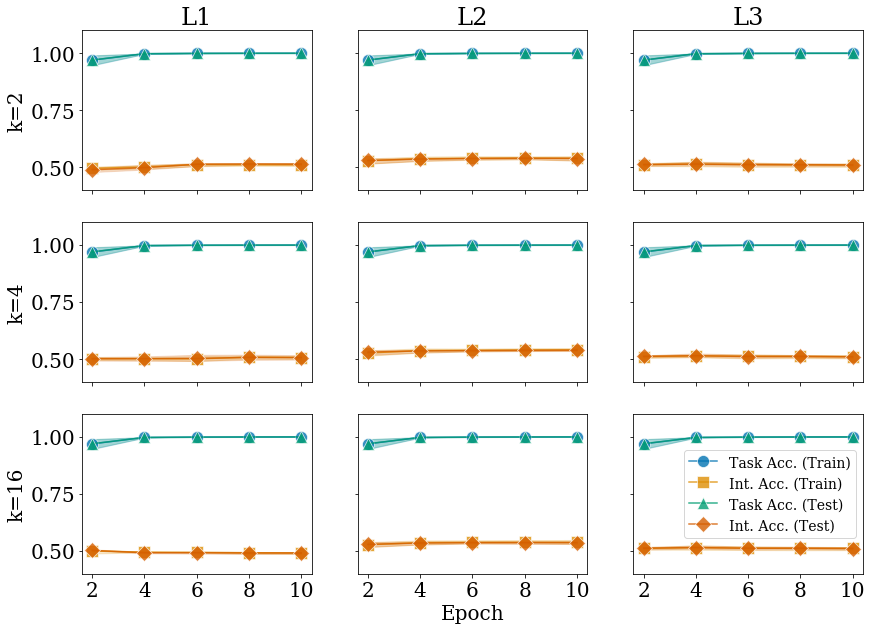

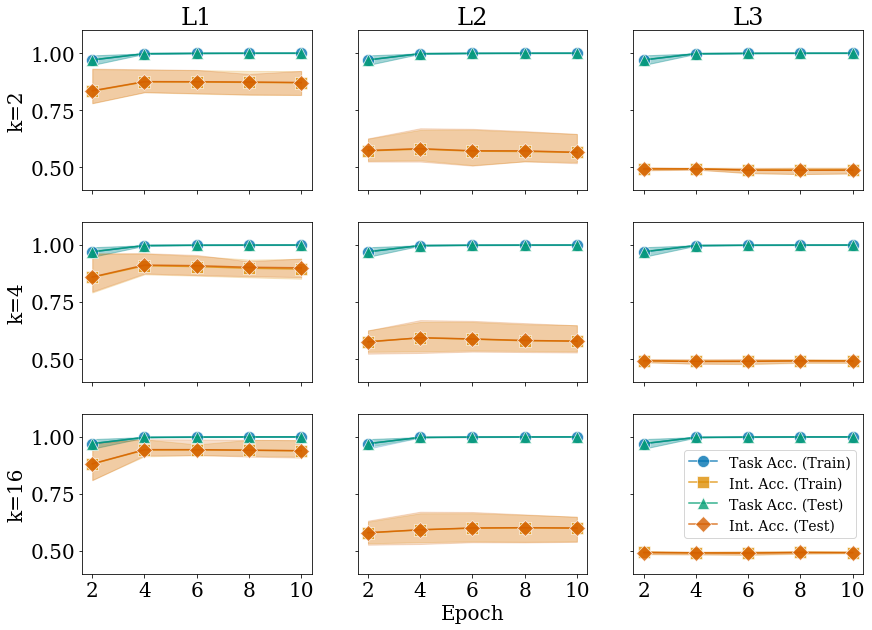

In [22]:
hidden_dims = [16, 32]
SCMs = ["oracle", "control-0", "control-0-1"]
sns.set_palette("colorblind")

for hidden_dim in hidden_dims:
    for SCM in SCMs:

        if SCM == "oracle":
            df = oracle_df
        elif SCM == "control-0":
            df = control_0_df
        elif SCM == "control-0-1":
            df = control_0_1_df

        plt.rcParams["font.family"] = "DejaVu Serif"
        font = {'family' : 'DejaVu Serif',
                'size'   : 20}
        plt.rc('font', **font)
        fig, axes = plt.subplots(3, 3, figsize=(14,10))

        hidden_dim_per_concepts = [0.5, 1, 4]
        iit_layers = [1, 2, 3]
        if hidden_dim == 16:
            ylabels = [f"k=1", f"k=2", f"k=8"]
        else:
            ylabels = [f"k=2", f"k=4", f"k=16"]
        for i in range(3):
            for j in range(3):
                hidden_dim_per_concept = hidden_dim_per_concepts[i]
                iit_layer = iit_layers[j]
                df_toplot = df[(df["hidden_dim_per_concept"]==hidden_dim_per_concept)&
                   (df["iit_layer"]==iit_layer)&
                   (df["hidden_dim"]==hidden_dim)&
                   ((df["type"]=="Factual Train")|
                    (df["type"]=="d-IIT Train")
                    |(df["type"]=="Factual Test")
                    |(df["type"]=="d-IIT Test"))
                ]
                sns.lineplot(
                    ax=axes[i,j],
                    data=df_toplot,
                    x="epoch", y="f1-score", hue="type", style="type",
                    dashes=False, markers=['o', 's', '^', 'D'], markersize=12, legend=False,
                    alpha=0.8
                )
                axes[i,j].set_ylim(0.4, 1.1)
                if i == 2:
                    axes[i,j].set(xlabel="Epoch" if j == 1 else None, xticks=[2, 4, 6, 8, 10], xticklabels=[2, 4, 6, 8, 10])
                else:
                    axes[i,j].set(xlabel=None, xticks=[2, 4, 6, 8, 10], xticklabels=[])
                if j == 0:
                    axes[i,j].set(ylabel=ylabels[i])
                else:
                    axes[i,j].set(ylabel=None, yticklabels=[])

        axes[0,0].set_title("L1")
        axes[0,1].set_title("L2")
        axes[0,2].set_title("L3")

        plt.legend(loc='center right', labels=['Task Acc. (Train)', 'Int. Acc. (Train)', 
                                               'Task Acc. (Test)', 'Int. Acc. (Test)'], fontsize=14)

        plt.savefig(f"./fig/d-IIT-{hidden_dim}-{SCM}.png",dpi=200, bbox_inches='tight')
        

In [8]:
def generate_main_result_table(
    oracle_df,
    control_0_df,
    control_0_1_df,
    epoch = 10,
    hidden_dim = 32,
    reduce=max,
    eval_setting="d-IIT Train",
    round_to=2
):
    rows = []
    for hidden_dim_per_concept in [0.5, 1, 4]:
        row_scores = []
        for df in [oracle_df, control_0_1_df, control_0_df]:
            selected_scores = []
            for iit_layer in [1, 2, 3]:
                selected_score = reduce(df[
                    (df["hidden_dim_per_concept"]==hidden_dim_per_concept)&
                    (df["iit_layer"]==iit_layer)&
                    (df["hidden_dim"]==hidden_dim)&
                    (df["epoch"]==epoch)&
                    (df["type"]==eval_setting)
                ]["f1-score"].tolist())
                selected_scores += ["%.2f" % round(selected_score, round_to)]
            row_scores.extend(selected_scores)
        rows += [row_scores]
    df = pd.DataFrame(
        rows, 
        columns=[
            "L1;SCM1", "L2;SCM1", "L3;SCM1", 
            "L1;SCM2", "L2;SCM2", "L3;SCM2", 
            "L1;SCM3", "L2;SCM3", "L3;SCM3"
        ]
    )
    return df

In [9]:
generate_main_result_table(
    oracle_df,
    control_0_df,
    control_0_1_df
).to_latex()

'\\begin{tabular}{llllllllll}\n\\toprule\n{} & L1;SCM1 & L2;SCM1 & L3;SCM1 & L1;SCM2 & L2;SCM2 & L3;SCM2 & L1;SCM3 & L2;SCM3 & L3;SCM3 \\\\\n\\midrule\n0 &    0.93 &    0.63 &    0.49 &    0.92 &    0.65 &    0.50 &    0.52 &    0.55 &    0.52 \\\\\n1 &    0.97 &    0.63 &    0.49 &    0.94 &    0.65 &    0.50 &    0.51 &    0.55 &    0.52 \\\\\n2 &    0.99 &    0.67 &    0.53 &    0.99 &    0.65 &    0.50 &    0.49 &    0.55 &    0.52 \\\\\n\\bottomrule\n\\end{tabular}\n'